In [1]:
import pandas as pd
data = pd.read_csv("/content/sample_data/habr_articles.csv")
df = data.drop(["Просмотры", "Время чтения","Ссылка"], axis=1).head()
df

,Название,Текст,Ключевые слова
0,Анонимные мессенджеры: лучшие решения для конф...,В наше время защита приватности и данных чрезв...,"Информационная безопасность*, Мессенджеры*, Ст..."
1,B2B UX: Информационная архитектура и проектиро...,В чём часто заключается проблема стартовой стр...,"Блог компании КОРУС Консалтинг, Анализ и проек..."
2,7 продвинутых приемов pandas для науки о данных,Pandas — это основная библиотека для работы с ...,"Python*, SQL*, PostgreSQL*, Data Engineering*"
3,Тестирование BMС: поговорим о нагрузочном тест...,"Хабр, привет! Мы в компании Аквариус стремимся...","Блог компании ПК Аквариус, Тестирование IT-сис..."
4,Крупные и не очень производители электроники п...,Привет! Это Даша Волкова из МТС Диджитал. В ок...,"Блог компании МТС, Производство и разработка э..."


In [4]:
import re
from gensim.models import Word2Vec, FastText

texts = df["Текст"].fillna("").astype(str)
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    return text

texts = texts.apply(clean_text)
tokenized_texts = texts.apply(lambda x: x.split())
# genmsim
word2vec_model = Word2Vec(tokenized_texts, vector_size=100, window=5, min_count=2, workers=4)
fasttext_model = FastText(tokenized_texts, vector_size=100, window=5, min_count=2, workers=4)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 1),
    max_df=0.85,
    min_df=2
)

tfidf_matrix = vectorizer.fit_transform(texts)
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_scores = dict(zip(tfidf_feature_names, vectorizer.idf_))

In [8]:
import numpy as np

def get_weighted_vector(text_tokens, model, tfidf_scores):
    word_vectors = []
    for word in text_tokens:
        if word in model.wv and word in tfidf_scores:
            word_vectors.append(model.wv[word] * tfidf_scores[word])
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

weighted_vectors_w = tokenized_texts.apply(lambda x: get_weighted_vector(x, word2vec_model, tfidf_scores))
weighted_vectors_f = tokenized_texts.apply(lambda x: get_weighted_vector(x, fasttext_model, tfidf_scores))
weighted_matrix_w = np.array(weighted_vectors_w.tolist())
weighted_matrix_f = np.array(weighted_vectors_f.tolist())

print("Size:", weighted_matrix_w.shape, weighted_matrix_f.shape)

Size: (5, 100) (5, 100)


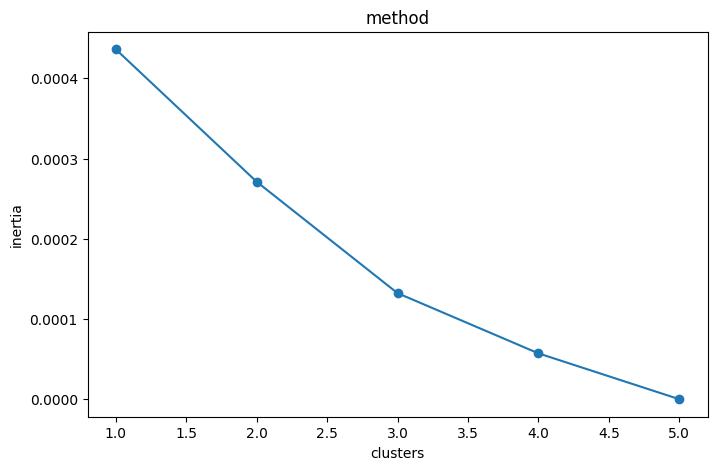

In [10]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_elbow_method(data, max_k=5):
    inertias = []
    k_values = range(1, max_k + 1)
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        inertias.append(kmeans.inertia_)

    # Plotting the elbow method
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, inertias, marker='o')
    plt.title("method")
    plt.xlabel("clusters")
    plt.ylabel("inertia")
    plt.show()

plot_elbow_method(weighted_matrix_f)


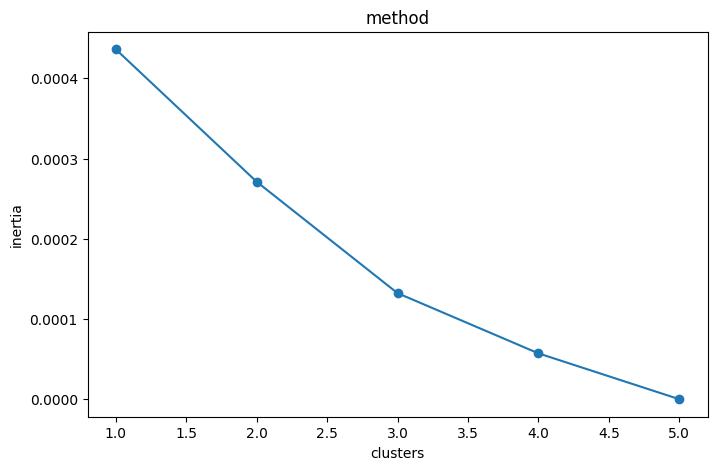

cluster
1    3
2    1
0    1
Name: count, dtype: int64

example 0:
4    Привет! Это Даша Волкова из МТС Диджитал. В ок...
Name: Текст, dtype: object

example 1:
0    В наше время защита приватности и данных чрезв...
2    Pandas — это основная библиотека для работы с ...
3    Хабр, привет! Мы в компании Аквариус стремимся...
Name: Текст, dtype: object

example 2:
1    В чём часто заключается проблема стартовой стр...
Name: Текст, dtype: object


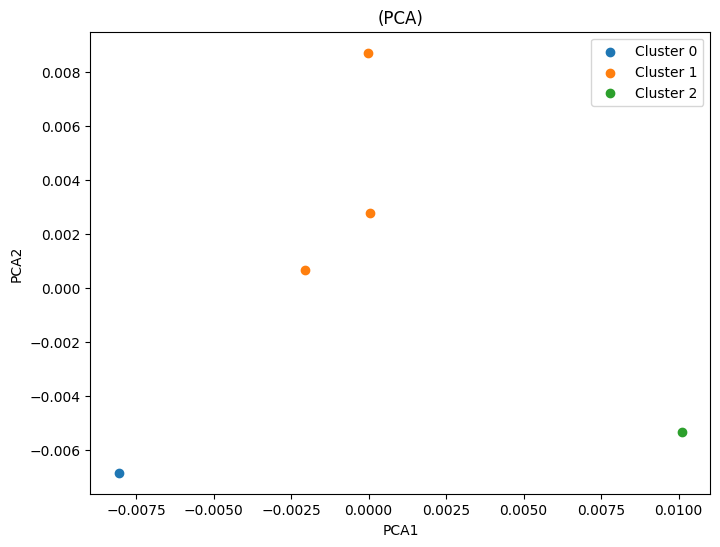

In [13]:
plot_elbow_method(weighted_matrix_f, max_k=5)

optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(weighted_matrix_f)

df['cluster'] = clusters
print(df['cluster'].value_counts())


for cluster_num in range(optimal_k):
    print(f"\nexample {cluster_num}:")
    examples = df[df['cluster'] == cluster_num]['Текст'].head(5)
    print(examples)

pca = PCA(n_components=2, random_state=42)
reduced_data = pca.fit_transform(weighted_matrix_f)

plt.figure(figsize=(8, 6))
for cluster_num in range(optimal_k):
    cluster_data = reduced_data[clusters == cluster_num]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f"Cluster {cluster_num}")

plt.title("(PCA)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.show()